In [1]:
pip install codecarbon

   ---------------------------------------- 0.0/494.9 kB ? eta -:--:--
    --------------------------------------- 10.2/494.9 kB ? eta -:--:--
   -- ------------------------------------ 30.7/494.9 kB 435.7 kB/s eta 0:00:02
   ---- ---------------------------------- 61.4/494.9 kB 409.6 kB/s eta 0:00:02
   ------ -------------------------------- 81.9/494.9 kB 508.4 kB/s eta 0:00:01
   ------- ------------------------------- 92.2/494.9 kB 438.1 kB/s eta 0:00:01
   ------------- ------------------------ 174.1/494.9 kB 615.9 kB/s eta 0:00:01
   --------------- ---------------------- 204.8/494.9 kB 692.4 kB/s eta 0:00:01
   --------------- ---------------------- 204.8/494.9 kB 692.4 kB/s eta 0:00:01
   ---------------------- --------------- 286.7/494.9 kB 707.1 kB/s eta 0:00:01
   --------------------------- ---------- 358.4/494.9 kB 768.6 kB/s eta 0:00:01
   --------------------------- ---------- 358.4/494.9 kB 768.6 kB/s eta 0:00:01
   ------------------------------------ - 471.0/494.9 kB 

Error processing line 1 of c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [2]:
! codecarbon init


Error processing line 1 of c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\vision-1.0.0-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
[codecarbon ERROR @ 18:33:43] ApiClient Error when calling the API on https://api.codecarbon.io/experiment with : {"timestamp": "2024-05-24T18:33:40.044358+05:30", "name": "Code Carbon user test", "description": "Code Carbon user test with default project", "on_cloud": false, "project_id": "e60afa92-17b7-4720-91a0-1ae91e409ba1", "country_name": "France", "country_iso_code": "FRA", "region": "france", "cloud_provider": null, "cloud_region": null}
[codecarbon ERROR @ 18:33:43] ApiClient API return http code 500 and

In [1]:
import codecarbon
[codecarbon]
log_level = "DEBUG"
save_to_api = True
experiment_id = "6d51d41f-c5f4-404c-b6f4-3223f6a37a79"  #the experiment_id you get with init

In [2]:

from codecarbon import EmissionsTracker
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')


# We load the data
data = pd.read_csv("ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
#This line extracts a subset of the loaded data. It takes the last 503 rows ([-503:]) and all columns except the last two ([:,:-2]).
data = data.values[-555:,:-2]

# We train on 2022 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2023 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

print(train[:5])

[[102.5 100.550003]
 [100.650002 99.849998]
 [99.5 99.849998]
 [101.400002 100.199997]
 [101.0 108.699997]]


C:\Users\hp\AppData\Local\Temp\ipykernel_18076\3919731544.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


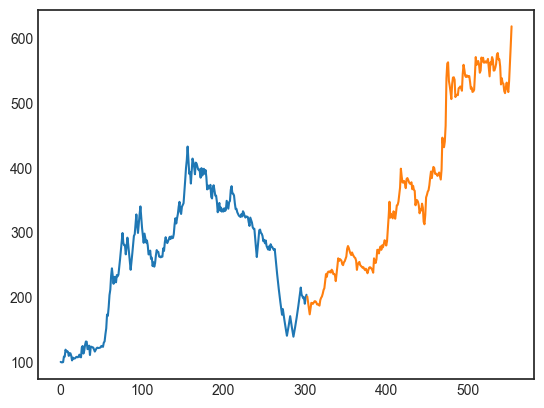

In [3]:
plt.plot(np.arange(len(train_Y)), train_Y)
plt.plot(np.arange(len(train_Y), len(test_Y) + len(train_Y)), test_Y)

In [4]:
# Initialize arrays to store the prior mean (mu), the logarithm of the prior covariance (log_p), and the logarithm of the Kalman gain (log_k).
#Set the initial values for log_p and mu[0].

#carbon emission
tracker=EmissionsTracker()
tracker.start()



def pre_filtering(x, a, b, c, f):

  T = len(x)

#mu prior mean log_p prior covariance mean log_k kalman gain logarithm
  mu = np.zeros(shape=(T))
  log_p = np.zeros(shape=(T))
  log_k = np.zeros(shape=(T))
  log_p[0] = 2
  mu[0] = x[0]

#T corresponds to the number of time steps or observations for which the filter is applied.
#It represents the length of the time series data over which the Kalman filter iterates to estimate the state of the system at each time step.
  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]    #Update Prior Mean (mu[t]): Update the prior mean at time step t using the dynamic model.
    log_p[t] = logsumexp([np.log(b**2) + log_p[t-1], np.log(c**2)])  #Update Logarithm of Prior Covariance (log_p[t]): Update the logarithm of the prior covariance at time step t based on the dynamic model parameters b and measurement noise c.
    log_k[t] = log_p[t-1] - logsumexp([log_p[t-1], np.log(f**2)])   # updating kaldman gain
  return mu, log_p, log_k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, log_p, log_k = pre_filtering(x, a, b, c, f)  #callinf pre filtering function to get prior mean and covariance

  mu_filt = np.zeros(shape=(T))  # initialise to store filtered mean
  p_filt = np.zeros(shape=(T))   #initialise array to store covariance filtered

  for t in range(T):
    mu_filt[t] = mu[t] + np.exp(log_k[t])*(y[t] - mu[t])  #update filtered mean at t time using  pre-filtered mean, Kalman gain, and observation.
    p_filt[t] = (f**2) * np.exp(log_k[t])  #Update the filtered covariance at time step t using the pre-filtered covariance and the measurement noise.

  return mu_filt, p_filt


  #The Kalman gain is computed based on the predicted covariance and the measurement noise.
  #It represents the trade-off between the predicted state and the observed measurement

[codecarbon WARNING @ 06:26:18] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 06:26:18] [setup] RAM Tracking...
[codecarbon INFO @ 06:26:18] [setup] GPU Tracking...
[codecarbon INFO @ 06:26:18] No GPU found.
[codecarbon INFO @ 06:26:18] [setup] CPU Tracking...
[codecarbon WARNING @ 06:26:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 06:26:21] CPU Model on constant consumption mode: AMD Ryzen 3 5300U with Radeon Graphics
[codecarbon INFO @ 06:26:21] >>> Tracker's metadata:
[codecarbon INFO @ 06:26:21]   Platform system: Windows-10-10.0.22621-SP0
[codecarbon INFO @ 06:26:21]   Python version: 3.9.13
[codecarbon INFO @ 06:26:21]   CodeCarbon version: 2.4.2
[codecarbon INFO @ 06:26:21]   Available RAM : 7.327 GB
[codecarbon INFO @ 06:26:21]   CPU count: 8
[codecarbon INFO @ 06:26:21]   CPU model: AMD Ryzen 3 5300U with Radeon Graphics
[codecarbon INFO @ 06:26:21]   GPU count: None
[codecarbon INFO @ 06:26:21]   GPU m

In [5]:

x = train_Y
y = train_X

T = len(y)

x_t = x[1:]
x_t_1 = x[:-1]

f_2 = ((y - x)**2).sum() / len(y)
b = ((T-1)*(x_t * x_t_1).sum() - x_t.sum() * x_t_1.sum())/((T-1)*((x_t_1**2).sum()) - x_t_1.sum()**2)
a = (x_t - b*x_t_1).sum() / (T-1)
c_2 = ((x_t - a - b*x_t_1)**2).sum() / (T-1)

print(np.sqrt(f_2), b, a, np.sqrt(c_2))

8.400283127600186 0.9906765081257176 2.7574409757331244 9.054082501797044


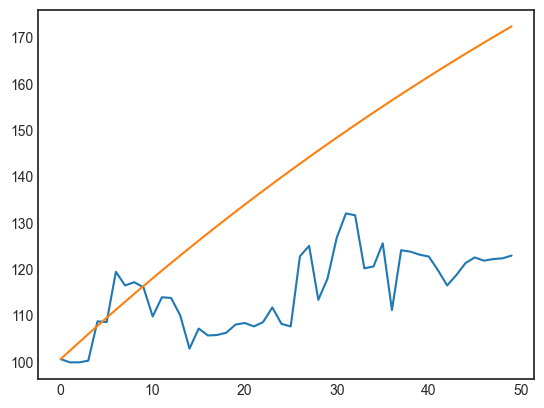

In [6]:
mu, log_p, log_k = pre_filtering(x, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu[:50])

2.4702808924549147


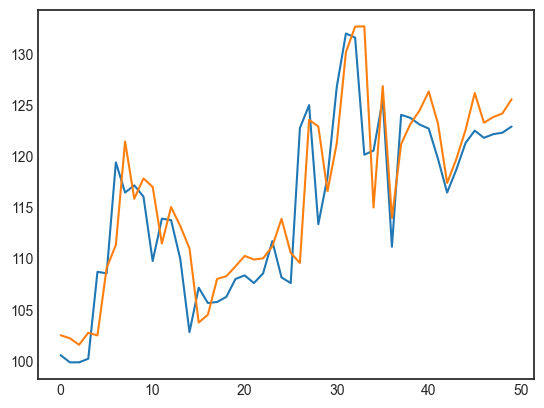

In [7]:
mu_filt, p_filt = filtering(x, y, a, b, np.sqrt(c_2), np.sqrt(f_2))
plt.plot(np.arange(50), x[:50])
plt.plot(np.arange(50), mu_filt[:50])



print(np.mean(np.abs((x - mu_filt) / x)) * 100)

[codecarbon INFO @ 06:26:38] Energy consumed for RAM : 0.000009 kWh. RAM Power : 2.7474846839904785 W
[codecarbon INFO @ 06:26:38] Energy consumed for all CPUs : 0.000024 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 06:26:38] 0.000033 kWh of electricity used since the beginning.


Emission :7.866837920458924e-08 kg
worst baseline  2.026084083090855
current baseline  1.9818004113219985


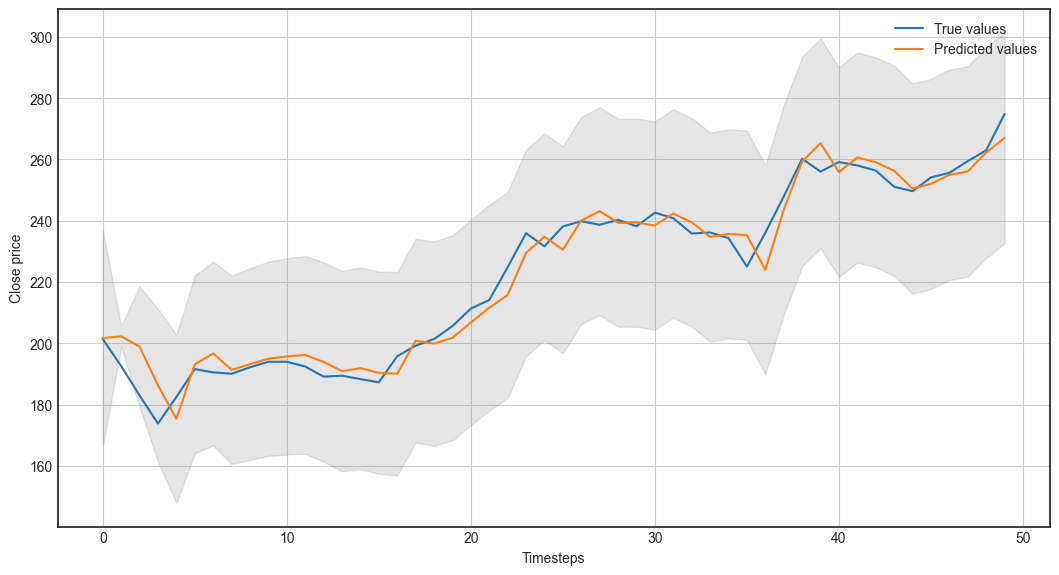

In [8]:

def log_gaussian(mu, sigma, x):
  part1 = np.sqrt(2*np.pi)*sigma
  part2 = -0.5 * (x - mu)**2 * (1/sigma**2)
  return -np.log(part1) + part2

x_test = test_Y
y_test = test_X

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

emissions: float = tracker.stop()
print(f"Emission :{emissions} kg")

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()
#Worst Baseline: The "worst baseline" calculates the MAPE by using the last observed value from the test data as the baseline for comparison. In other words,
# it measures the error of the prediction relative to the most recent observed value in the test data.
print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
# The "current baseline" calculates the MAPE by using the current prediction value as the baseline for comparison.
# In this case, the error is measured relative to the current predicted value.
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)


In [9]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from scipy.special import logsumexp
plt.style.use('seaborn-white')

# We load the data
data = pd.read_csv("ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-555:,:-2]

# We train on 2022 data and we consider only open and high price
train = data[:-252,[1,4]]
train_X = train[:,0]
train_Y = train[:,1]
# We test on 2023 data
test = data[-252:,[1,4]]
test_X = test[:,0]
test_Y = test[:,1]

# Compute the difference in price
diffs = train_X[:-1] - train_X[1:]

# If the difference is positive then label 1 otherwise label 0
labels = np.where(diffs >= 0, 1, 0)

# For the first element of the time series we can put either 0 or 1
labels = np.insert(labels, 0, 0)

# Do the same thing for the test set
diffs_test = test_X[:-1] - test_X[1:]
diffs_test = np.insert(diffs_test, 0, test_X[0] - train_X[-1])
labels_test = np.where(diffs_test >= 0, 1, 0)

C:\Users\hp\AppData\Local\Temp\ipykernel_18076\1418428698.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [10]:
#exp
def filtering_with_dates(x, y, dates, a, b, c, f):
    T = len(y)
    mu, p, k = pre_filtering(x, a, b, c, f)

    mu_filt = np.zeros(shape=(T))
    p_filt = np.zeros(shape=(T))


    for t in range(T):
        mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
        p_filt[t] = (f**2) * k[t]
        print("Predicted value for date", dates[t], ":", mu_filt[t])  # Modified print statement

    return mu_filt, p_filt


In [11]:
#exp
import datetime

start_date = datetime.date(2023, 1, 9)  # Replace this with your actual start date
num_days = len(test_Y)  # Assuming the length of test_Y is the number of days

test_dates = [start_date + datetime.timedelta(days=i) for i in range(num_days)]


Predicted value for date 2023-01-09 : 201.399994
Predicted value for date 2023-01-10 : 202.47391149649417
Predicted value for date 2023-01-11 : 197.21803271768505
Predicted value for date 2023-01-12 : 183.301056847015
Predicted value for date 2023-01-13 : 172.54145174355205
Predicted value for date 2023-01-14 : 192.38564897154046
Predicted value for date 2023-01-15 : 196.2954039369572
Predicted value for date 2023-01-16 : 190.85067692232212
Predicted value for date 2023-01-17 : 192.84705498234777
Predicted value for date 2023-01-18 : 194.71227986269463
Predicted value for date 2023-01-19 : 195.5073622032894
Predicted value for date 2023-01-20 : 196.03960331968818
Predicted value for date 2023-01-21 : 193.7382840987996
Predicted value for date 2023-01-22 : 190.76525911707165
Predicted value for date 2023-01-23 : 191.7199706742082
Predicted value for date 2023-01-24 : 190.23460475179948
Predicted value for date 2023-01-25 : 189.92554202806306
Predicted value for date 2023-01-26 : 200.800

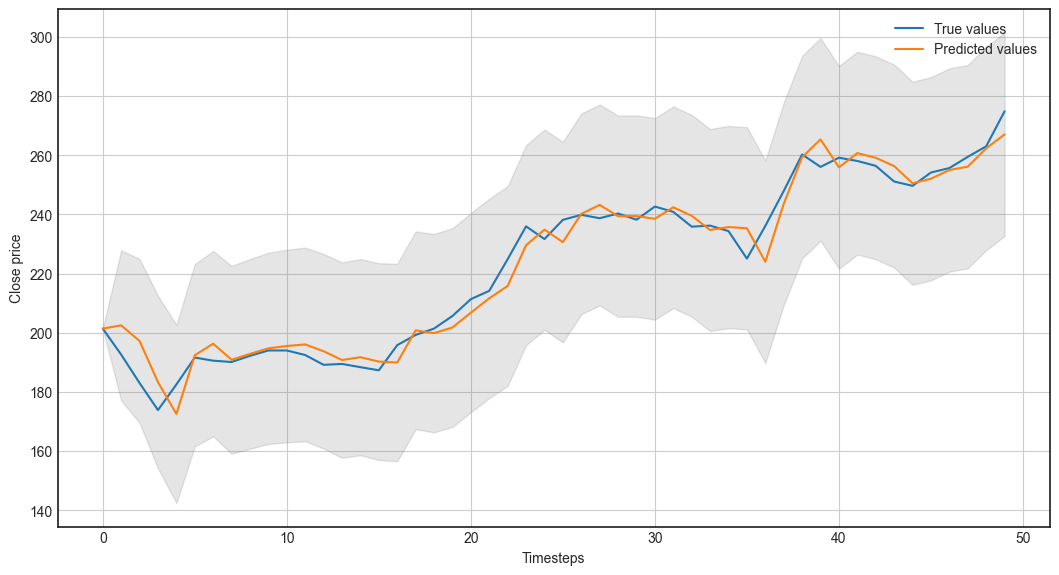

In [12]:

def pre_filtering(x, a, b, c, f):

  T = len(x)

  mu = np.zeros(shape=(T))
  p = np.zeros(shape=(T))
  k = np.zeros(shape=(T))
  p[0] = 100
  mu[0] = x[0]

  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]
    p[t] = (b**2) * p[t-1] + c**2
    k[t] = p[t] / (p[t] + f**2)

  return mu, p, k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, p, k = pre_filtering(x, a, b, c, f)

  mu_filt = np.zeros(shape=(T))
  p_filt = np.zeros(shape=(T))

  for t in range(T):
    mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
    p_filt[t] = (f**2) * k[t]
    #print("Predicted value at time", t+1, ":", mu_filt[t])

  return mu_filt, p_filt

x_test = test_Y
y_test = test_X
dates_test = test_dates  # Assuming test dates corresponding to each data point

mu_fore, p_fore = filtering_with_dates(x_test, y_test, dates_test, a, b, np.sqrt(c_2), np.sqrt(f_2))
mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

plt.figure(figsize=(6.4*2, 4.8*1.4))
plt.plot(np.arange(50), x_test[:50])
plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline ', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline ', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)


In [13]:
def calculate_mape(true_values, predicted_values):
    return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

# Calculate Root Mean Squared Error (RMSE)
def calculate_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values)**2))

# Assuming x_test contains true values and mu_fore contains predicted values
mape = calculate_mape(x_test, mu_fore)
rmse = calculate_rmse(x_test, mu_fore)

print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 1.9706094627117656
RMSE: 11.292479101517397


In [14]:
# Convert x_test to a NumPy array with float64 data type
x_test_np = np.array(x_test, dtype=np.float64)

# Calculate the accuracy metrics in log scale
log_true_values = np.log(x_test_np)
log_predicted_values = np.log(mu_fore)

log_mae = np.mean(np.abs(log_true_values - log_predicted_values))
log_mse = np.mean((log_true_values - log_predicted_values)**2)
log_rmse = np.sqrt(log_mse)
log_mape = np.mean(np.abs((log_true_values - log_predicted_values) / log_true_values)) * 100

print("LOG_MAE: ",log_mae, "LOG_MSE: ",log_mse,"LOG_RMSE : ",log_rmse,"LOG_MAPE ",log_mape)

LOG_MAE:  0.019833118304505622 LOG_MSE:  0.0008028476340360027 LOG_RMSE :  0.02833456606401451 LOG_MAPE  0.3395077478965318


In [ ]:
# model genration of lstm 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# We load the data